# ecflow course 2018
## import python script - ecf example

In [51]:
%%bash
module load ecflow/4.8.0
ecflow_start.sh -p 2500
# ecflow_ui&
cd $HOME/ecflow_server
mkdir -p files include

ping server(eurus:2500) succeeded in 00:00:00.000793  ~0 milliseconds
server is already started


load ecflow 4.8.0 (PATH)


In [52]:
%%bash
head=$HOME/ecflow_server/include/head.h
if [[ ! -f $head ]]; then
cat > $head <<@@
#!/bin/ksh
set -e # stop the shell on first error
set -u # fail when using an undefined variable
set -x # echo script lines as they are executed

# Defines the variables that are needed for any communication with ECF
export ECF_PORT=%ECF_PORT%    # The server port number
export ECF_HOST=%ECF_HOST%    # where the server is running
export ECF_NAME=%ECF_NAME%    # The name of this current task
export ECF_PASS=%ECF_PASS%    # A unique password
export ECF_TRYNO=%ECF_TRYNO%  # Current try number of the task
export ECF_RID=$$             # record the process id. Also used for
                              # zombie detection

# Define the path where to find ecflow_client
# make sure client and server use the *same* version.
# Important when there are multiple versions of ecFlow
export PATH=/usr/local/apps/ecflow/%ECF_VERSION%/bin:$PATH
export PATH=$PATH:/usr/local/apps/ecflow/bin

# Tell ecFlow we have started
ecflow_client --init=$$

# Define a error handler
ERROR() {
   set +e                      # Clear -e flag, so we don't fail
   wait                        # wait for background process to stop
   ecflow_client --abort=trap  # Notify ecFlow that something went
                               # wrong, using 'trap' as the reason
   trap 0                      # Remove the trap
   exit 0                      # End the script
}
@@
fi

In [53]:
%%bash
file=$HOME/ecflow_server/include/tail.h
if [[ ! -f $file ]]; then
cat > $file <<@@
wait           # wait for background process to stop
ecflow_client --complete  # Notify ecFlow of a normal end
trap 0                    # Remove all traps
exit 0                    # End the shell
@@
fi

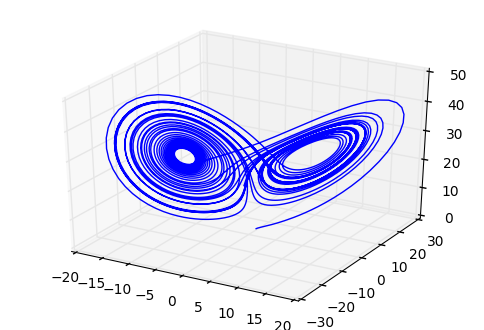

In [54]:
script = """# Thanks https://en.wikipedia.org/wiki/Lorenz_system
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0

def f(state,
t):
  x, y, z = state  # unpack the state vector
  return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # derivatives

state0 = [1.0, 1.0, 1.0]
t = np.arange(0.0, 40.0, 0.01)

states = odeint(f, state0, t)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(states[:,0], states[:,1], states[:,2])
plt.show()"""
exec(script)

In [60]:
import os
with open(os.getenv("HOME") + "/ecflow_server/files/compute.ecf", 'w') as fip:
    fip.write(
        """#!/bin/bash
%include <head.h>
python <<@@
""" + script.replace("[1.0, 1.0, 1.0]",
                     "%XYZ:[1.0, 1.0, 1.0]%") + """
@@
%include <tail.h>
""")

In [58]:
import sys
lib = "/usr/local/apps/ecflow/4.8.0/lib/python2.7/site-packages/ecflow"
sys.path.append(lib)

home = os.getenv("HOME") + "/ecflow_server"
user = os.getenv("USER")

import ecf
from ecf import *
node = Suite("lorenz").add(
    Defstatus("suspended"),
    ecf.Edit(ECF_HOME=home, ECF_INCLUDE=home + "/include", ECF_FILES=home + "/files",
             ECF_OUT=home, 
             ECF_EXTN=".ecf", USER=user, SCHOST="localhost",
 ECF_JOB_CMD="/home/ma/emos/bin/trimurti %USER% %SCHOST% %ECF_JOB% %ECF_JOBOUT%"),
    ecf.Family("ecf").add(
            Task("compute").add(),
        
    ecf.Family("multi").add(  # once imported, alter script, run multiple tasks
           [ecf.Family("%02d" % num).add(
              Edit(XYZ="[%d.0, %d.0, %d.0]" % (num, num, num)),
              Task("compute"))
            for num in xrange(0, 5)])))
client = ecf.Client("localhost@2500")
defs = ecf.Defs()
defs.add_suite(node)
client.replace("/lorenz", defs)

In [57]:
dot = node.draw_graph()  # compute shall be distinct nodes...
